# Detectability of sources
This is the experiment ran on a multiples simplified synthetic datasets. The datasets contain 2 magnetic anomalies cased by two dipoles. These two dipoles are at varying depths with an increased distance between them to assess the algorithm's ability to identify the sources individually.

## Imports

Load the modules needed to run the experiment.

In [1]:
import pathlib
import warnings
import rich.progress
import ipywidgets
from IPython.display import display
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import skimage.exposure
import harmonica as hm
import verde as vd
import mplstereonet
# Our custom module for this paper
import micromag as mg

In [2]:
# Ignore warnings coming from the Fourier transform module to avoid generating 100s of them.
warnings.filterwarnings("ignore", module="xrft")

## Generate a bunch of random models

In [3]:
models = []
distances = np.arange(10, 50,2)
for distance in distances:
    dipole_coordinates = (
        [75+(distance/2), 75-(distance/2)],
        [75, 75],
        [-1, -1]
    )
    dipole_moments = mg.angles_to_vector(
        inclination=[-90, -90],
        declination=[0, 0],
        amplitude=[1.0e-13, 1.0e-13],
    )
        
    models.append(
        (dipole_coordinates, dipole_moments)
    )

## Generate synthetic data

In [4]:
region = [0, 150, 0, 150]
x, y = vd.grid_coordinates(region=region, spacing=1)
sensor_sample_distances = vd.line_coordinates(4, 24, spacing=10.0)

synthetic_data = []
for dipole_coordinates, dipole_moments in models:
    data = []
    for distance in sensor_sample_distances:
        z = np.full_like(x, distance)
        coordinates = (x, y, z)
        bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
        bz += mg.gaussian_noise(error=20, shape=y.shape, seed=42)
        grid = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
        grid.x.attrs = {"units": "µm"}
        grid.y.attrs = {"units": "µm"}
        grid.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}        
        data.append(grid)
    synthetic_data.append(data)

Make a quick plot of one of the calculated fields.

In [5]:
# ipywidgets.interact(
#     lambda model, height: synthetic_data[model][height].bz.plot.pcolormesh(cmap="seismic"), 
#     model=(0, len(models) - 1), 
#     height=(0, len(sensor_sample_distances) - 1),
# )


In [6]:
def plot_synthetic_data(model, height):
    plt.figure() 
    synthetic_data[model][height].bz.plot.pcolormesh(cmap="seismic")
    current_title = f'height = {int(sensor_sample_distances[height]+1)} $\mu m$ | distance = {distances[model]} $\mu m$'  # Atualize o título
    plt.title(current_title, fontsize=11, loc='center')  # Defina o título
    plt.gca().set_aspect('equal')

# iteractive widgets
model_widget = ipywidgets.IntSlider(min=0, max=len(models) - 1, description='Model')
height_widget = ipywidgets.IntSlider(min=0, max=len(sensor_sample_distances) - 1, description='Height')

# iteractive interface
interactive_plot = ipywidgets.interactive(plot_synthetic_data, model=model_widget, height=height_widget)

display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Model', max=19), IntSlider(value=0, description='Height'…

In [7]:
results = []
height_difference = 7.5
for grids, (dipole_coordinates, dipole_moment) in rich.progress.track(zip(synthetic_data, models), total=len(models)):
    results_per_grid = []
    for anomaly in grids:
        # Upward cont.
        data_up = (
            hm.upward_continuation(anomaly.bz, height_difference)
            .assign_attrs(anomaly.bz.attrs)
            .to_dataset(name="bz")
            .assign_coords(x=anomaly.x, y=anomaly.y)
            .assign_coords(z=anomaly.z + height_difference)
        )
        # Gradient
        data_up = data_up.assign(mg.data_gradients(data_up.bz))
        
        # Stretch contrast
        
        stretched = skimage.exposure.rescale_intensity(
            data_up.tga, 
            in_range=tuple(np.percentile(data_up.tga, (0.5, 99.5))),
        )
        data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))
        
        # Window detection
        windows = mg.detect_anomalies(
            data_up.tga_stretched, 
            size_range=[10, 15],
            size_increment=1.2,
            threshold=0.25,
            overlap=1.0,
            exclude_border=0,
            nsizes=20
        ) 
        
        results_per_grid.append((windows))
    results.append(results_per_grid)  


Output()

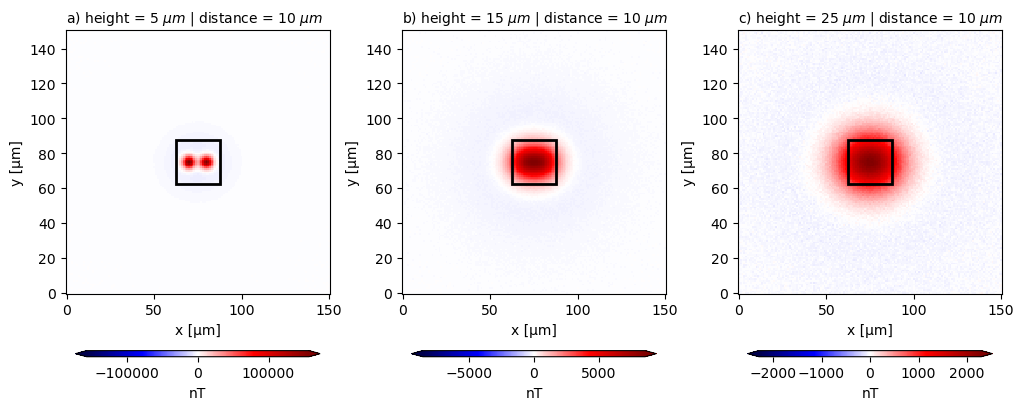

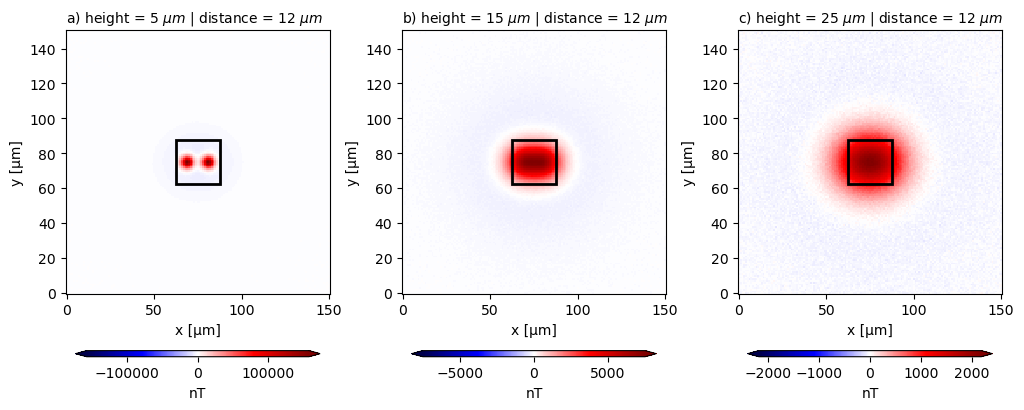

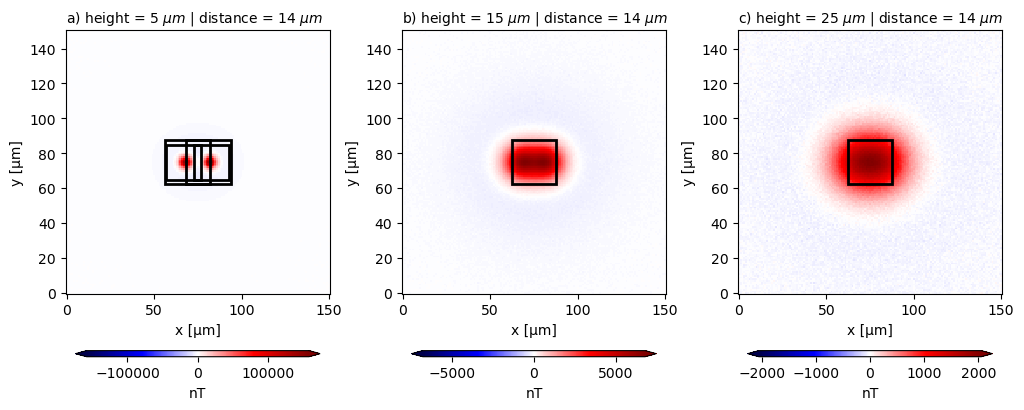

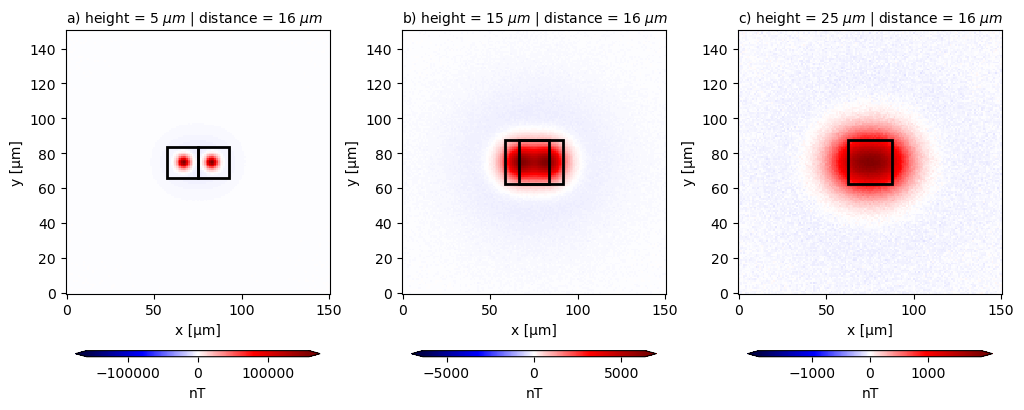

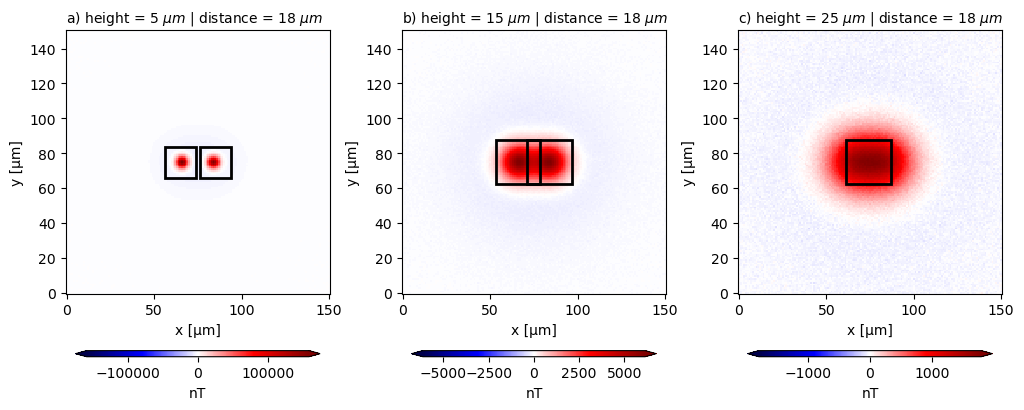

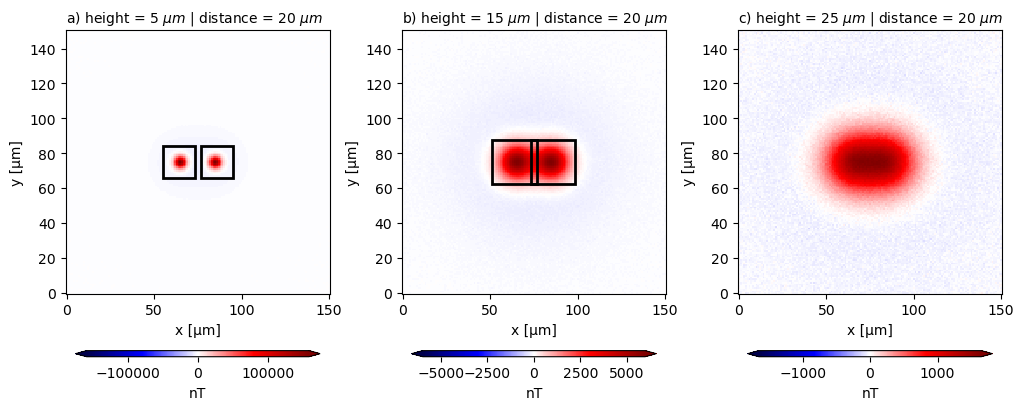

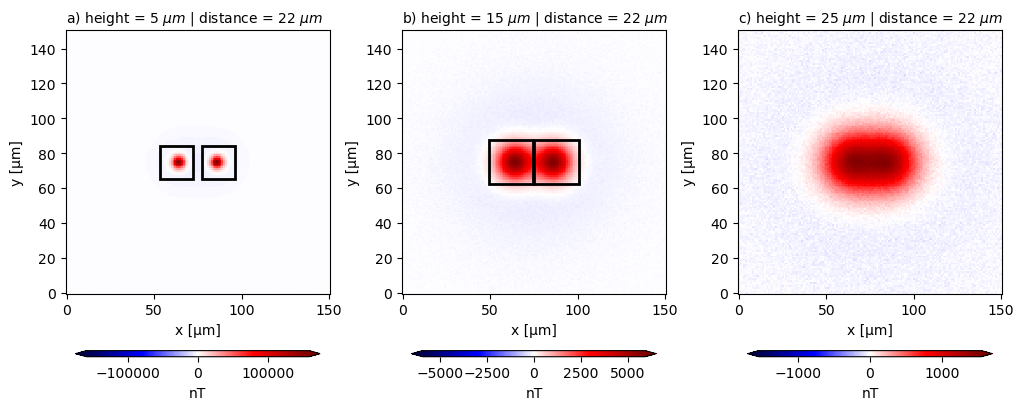

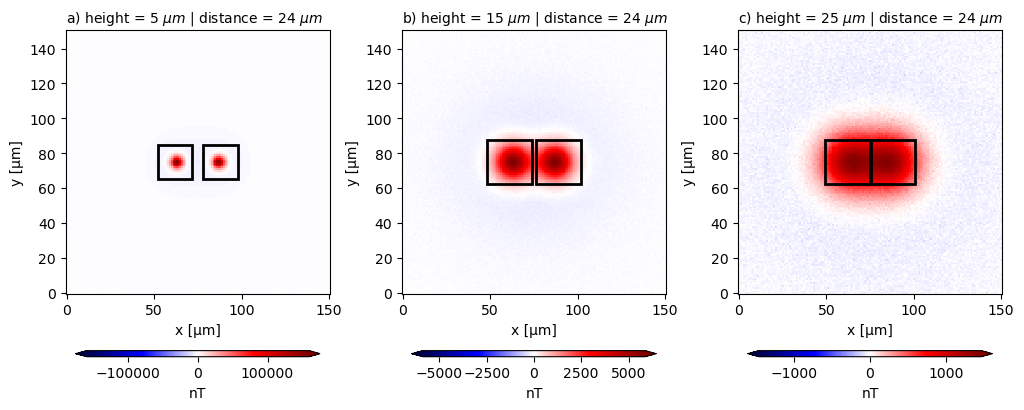

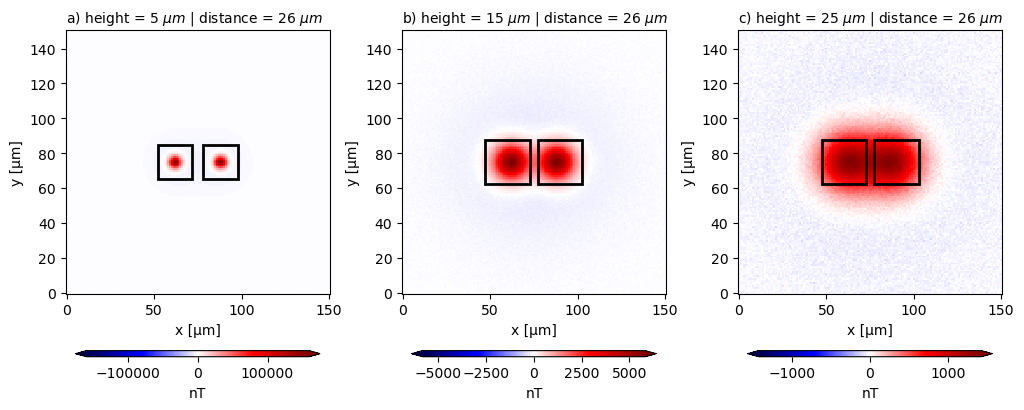

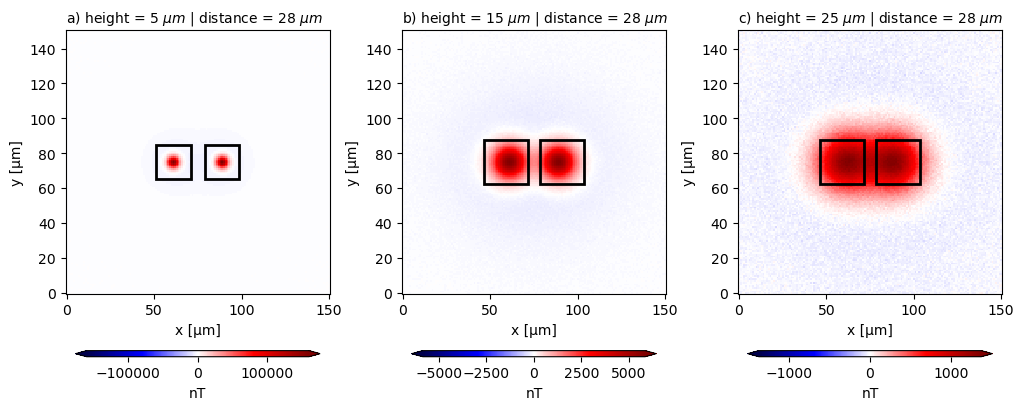

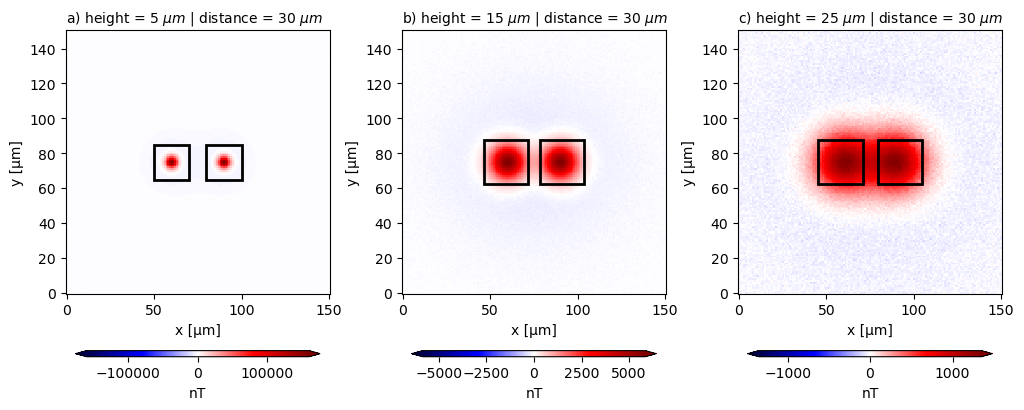

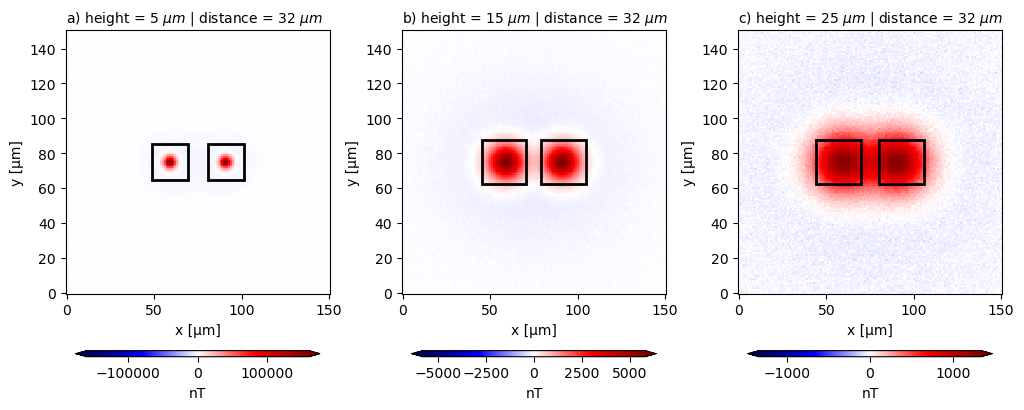

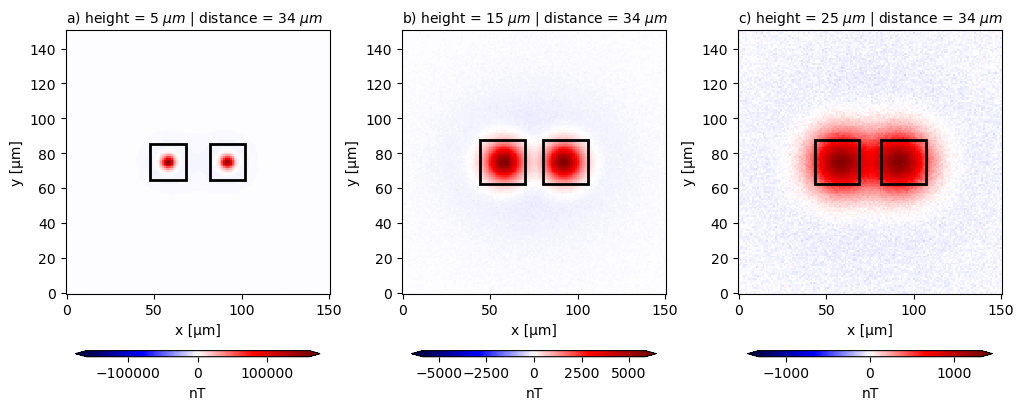

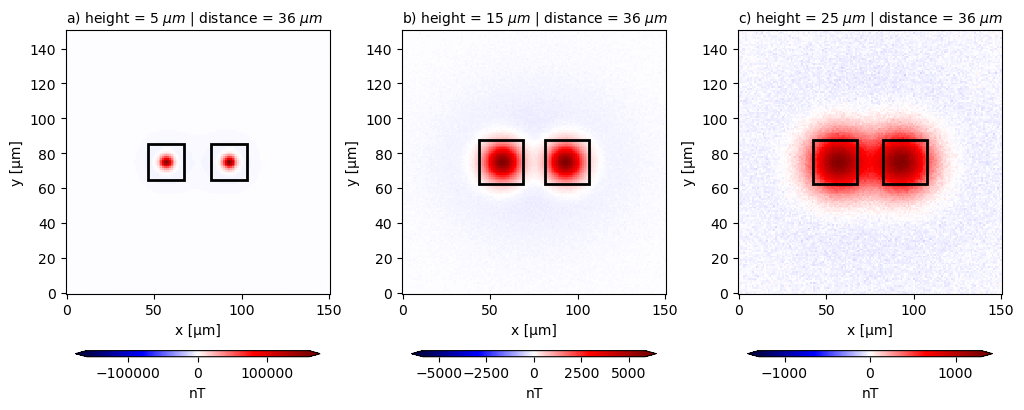

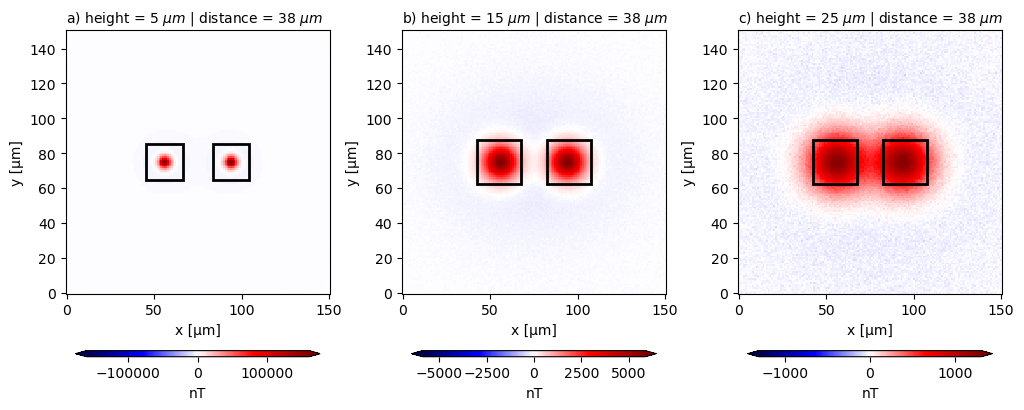

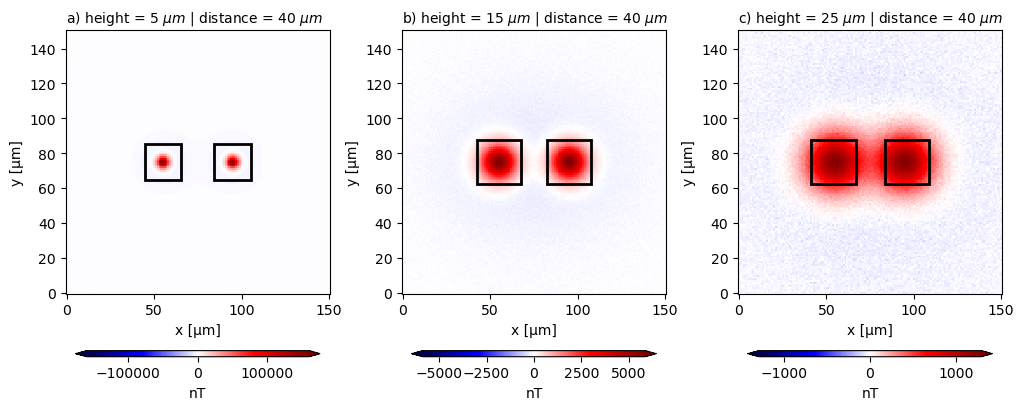

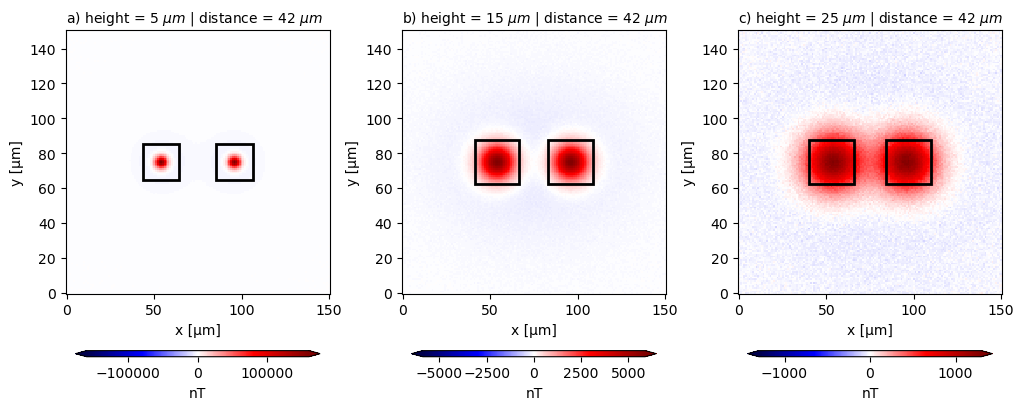

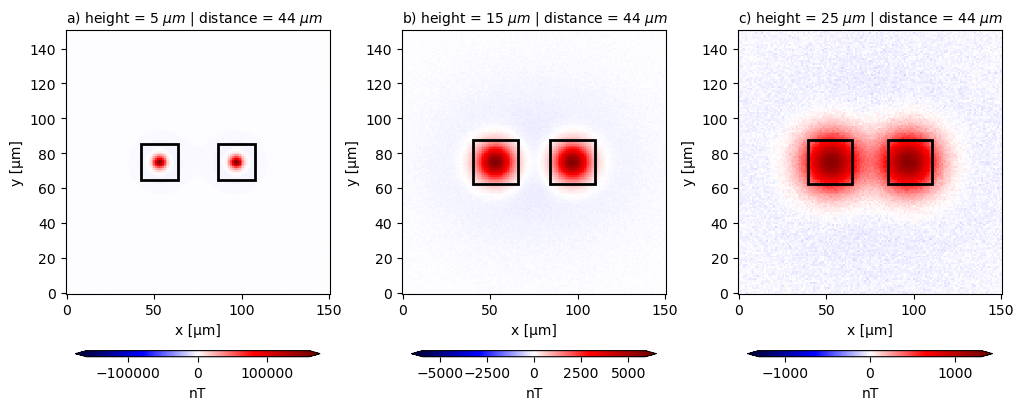

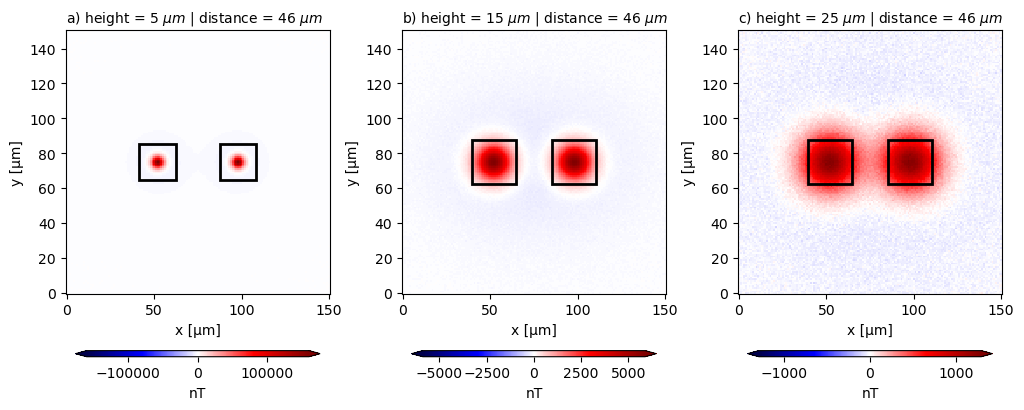

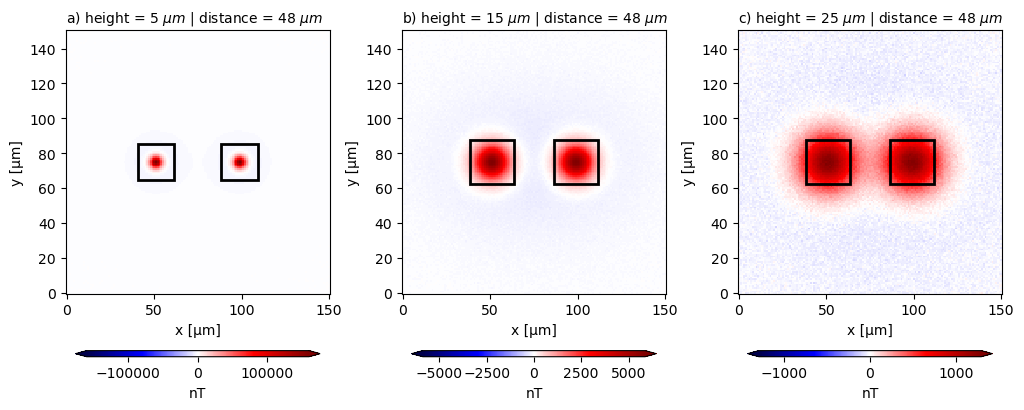

In [10]:
for i, (grid_windows, grids) in enumerate(zip(results, synthetic_data)):
    fig, axes = plt.subplots(1, len(grid_windows), figsize=(10, 4)) 
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    axes = axes.ravel()
    for j, (letter, windows, anomaly) in enumerate(zip(['a', 'b', 'c'],grid_windows, grids)):

        ax = axes[j]
        
        tmp = anomaly.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        ax.set_title(f'{letter}) height = {int(sensor_sample_distances[j]+1)} $\mu m$ | distance = {distances[i]} $\mu m$', 
                     fontsize=10, loc='left')
        for window in windows:

            rect = matplotlib.patches.Rectangle(
                xy=[window[0], window[2]],
                width=window[1] - window[0],
                height=window[3] - window[2],
                edgecolor="k",
                fill=False,
                linewidth=2,
            )
            ax.add_patch(rect)

        ax.set_aspect("equal")
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    plt.show()